# Imports and function definitions

In [1]:
from getdist import plots, MCSamples
%matplotlib inline
from matplotlib import pyplot as plt
import getdist
import h5py

import numpy as np
import os
import sacc
import scipy.stats
import sys
import yaml
from scipy.interpolate import interp1d
import pyccl as ccl
import latextable
from texttable import Texttable

from cobaya.samplers.mcmc import plot_progress
from getdist.mcsamples import MCSamplesFromCobaya

from scipy import stats
from scipy.interpolate import interp1d

from cobaya.model import get_model
from cobaya.input import load_input
from cl_like import ClLike

import healpy as hp
import sacc
import fitsio

#### Import baccoemu to check within ranges
import baccoemu
import warnings

nonlinear_emu_path='/mnt/zfsusers/gravityls_3/codes/NN_emulator_PCA6_0.95_300_400n_paired_comb'
nonlinear_emu_details='details.pickle'

mpk = baccoemu.Matter_powerspectrum(nonlinear_emu_path=nonlinear_emu_path,
                                    nonlinear_emu_details=nonlinear_emu_details)

#### Chain handling ####
class Chain(dict):
    def __init__(self, MCSamples, label, color, path, Cobaya=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self['MCSamples'] = MCSamples
        self['label'] = label
        self['color'] = color
        self['path'] = path
        # We subtract 4 for minuslogprior, minuslogprior__0, chi2, chi2__cl_like.ClLike
        # We load this at the beginning for correct R-1
        self['npar'] = len(MCSamples.getParamNames().list()) - 4      
        # self['R-1'] = MCSamples.getGelmanRubin(npar)
        self.model = None
        self.lkl = None
        self.Rminus1 = None
        self.chi2bf = None
        self.parsbf = None
        self.pvaluebf = None
        self.clsacc_bf = None
        self.cldata = None
        self._derived_added = False
        self.pk_data_bf = None
        self.ndata = None
        
    def _get_model(self):
        if self.model is None:
            path = self['path'] + '.input.yaml'
            if not os.path.isfile(path):
                raise ValueError('These chains are not from cobaya, so you cannot load the model')
            self.model = get_model(path)
        return self.model
    
    def _get_Rminus1(self):
        if self.Rminus1 is None:
            self.Rminus1 = self['MCSamples'].getGelmanRubin(self.get('npar'))
        return self.Rminus1
    
    def _get_chi2bf(self):
        if self.chi2bf is None:
            pars = self['MCSamples'].getParams()
            self.chi2bf = pars.chi2__cl_like.ClLike.min()
        return self.chi2bf
    
    def _get_parsbf(self):
        if self.parsbf is None:
            chain = self['MCSamples']
            pars = chain.getParams()
            self.parsbf = chain.getParamSampleDict(pars.chi2__cl_like.ClLike.argmin())
        return self.parsbf
    
    def _get_ndata(self):
        if self.ndata is None:
            model = self._get_model()
            self.ndata = model.likelihood['cl_like.ClLike'].ndata
        return self.ndata
    
    def get_pvalue(self, pars):
        chi2 = self.evaluate_model(pars)
        ndata = self._get_ndata()
        return 1 - stats.chi2.cdf(chi2, df=ndata - 2)
    
    def _get_pvaluebf(self):
        if self.pvaluebf is None:
            # pars = self._get_parsbf()
            # self.pvaluebf = self.get_pvalue(pars)
            chi2bf = self._get_chi2bf()
            ndata = self._get_ndata()
            self.pvaluebf = 1 - stats.chi2.cdf(chi2bf, df=ndata - 2)
        return self.pvaluebf
    
    def add_derived(self):
        if self._derived_added is True:
            return
        MCSamples = self['MCSamples']
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        
        # S8 = p.sigma8 * np.sqrt(p.Omega_m / 0.3)
        if ('S8' not in pn) and ('S_8' in pn):
            S8 = p.S_8
            MCSamples.addDerived(S8, 'S8', label='S_8')
           
        if ('h' not in pn) and ('H0' in pn):
            MCSamples.addDerived(p.H0/100, 'h', label='h')
        if ('Omega_c' not in pn) and ('Omega_cdm' in pn):
            MCSamples.addDerived(p.Omega_cdm, 'Omega_c', label=r'\Omega_c')

        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        if 'Omega_m' not in pn:
            Omega_m = p.Omega_b + p.Omega_c
            if 'm_nu' in pn:
                Omega_m +=  p.Omega_nu
            MCSamples.addDerived(Omega_m, 'Omega_m', label=r'\Omega_m')
        if 'sigma8' not in pn:
            if 'sigma_8' in pn:
                MCSamples.addDerived(p.sigma_8, 'sigma8', label=r'\sigma_8')
            elif 'S8' in pn:
                MCSamples.addDerived(p.S8 * np.sqrt(0.3 / p.Omega_m), 'sigma8', label=r'\sigma_8')
        if 'm_nu' in pn:
            m_nu = p.m_nu
            MCSamples.addDerived(p.m_nu/(93.14*p.h**2), 'Omega_nu', label=r'\Omega_\nu')
        else:
            m_nu = np.zeros_like(p.h)
            
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()            
        if ('S8' not in pn) and ('sigma8' in pn and 'Omega_m' in pn):
             MCSamples.addDerived(p.sigma8 * np.sqrt(p.Omega_m / 0.3), 'S8', label='S_8')
            
        # Baryon fraction
        MCSamples.addDerived(p.Omega_b / (p.Omega_c + p.Omega_b), 'baryon_fraction', label=r'\frac{\Omega_b}{\Omega_{\rm cold}}')
        
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        h = p.h 
        if 'omega_b' not in pn:
            MCSamples.addDerived(p.Omega_b * h**2, 'omega_b', label='\omega_b')
        if 'omega_c' not in pn:
            MCSamples.addDerived(p.Omega_c * h**2, 'omega_cdm', label='\omega_{cdm}')
        if 'omega_m' not in pn:
            MCSamples.addDerived(p.Omega_m * h**2, 'omega_m', label='\omega_{m}')
        
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        # Sigma12
        if 'S12' not in pn and (('A_s' in pn) or ('A_sE9' in pn)):
            pars = {
            'omega_cold':p.Omega_c + p.Omega_b,
            'omega_baryon': p.Omega_b,
            'A_s' : p.A_sE9*1e-9 if 'A_sE9' in pn else p.A_s,
            'ns': p.n_s,
            'hubble': p.h,
            'neutrino_mass': m_nu,
            'w0': np.full(p.h.size, -1),
            'wa': np.full(p.h.size, 0),
            'expfactor': np.full(p.h.size, 1)
            }
            try:
                sigma12 = mpk.get_sigma12(cold=False, **pars)
                S12 = sigma12 * (p.omega_m / 0.14)**0.4
                MCSamples.addDerived(sigma12, 'sigma12', label='\sigma_{12}')
                MCSamples.addDerived(S12, 'S12', label='S_{12}')
            except AssertionError as e:
                if 'out of bounds' in str(e):
                    warnings.warn(str(e) + " Not adding S12 for this chain.")
                    
        if 'sigma8_cold' not in pn and (('A_s' in pn) or ('A_sE9' in pn)):
            pars = {
            'omega_cold':p.Omega_c + p.Omega_b,
            'omega_baryon': p.Omega_b,
            'A_s' : p.A_sE9*1e-9 if 'A_sE9' in pn else p.A_s,
            'ns': p.n_s,
            'hubble': p.h,
            'neutrino_mass': m_nu,
            'w0': np.full(p.h.size, -1),
            'wa': np.full(p.h.size, 0),
            'expfactor': np.full(p.h.size, 1)
            }
            try:
                sigma8_cold = mpk.get_sigma8(cold=True, **pars)
                MCSamples.addDerived(sigma8_cold, 'sigma8_cold', label='\sigma_{8,cold}')
            except AssertionError as e:
                if 'out of bounds' in str(e):
                    warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")
            
        return
    
    def __getitem__(self, key):
        if key not in self.keys():
            if key == 'model':
                self[key] = self._get_model()
            elif key == 'lkl':
                self[key] = self.get_lkl()
            elif key == 'R-1':
                self[key] = self._get_Rminus1()
            elif key == 'chi2bf':
                self[key] = self._get_chi2bf()
            elif key == 'pars_bf':
                self[key] = self._get_parsbf()
            elif key == 'ndata':
                self[key] = self._get_ndata()
            elif key == 'pvalue_bf':
                self[key] = self._get_pvaluebf()
            elif key == 'data_sacc':
                self[key] = self.get_cl_data_sacc()
            elif key == 'bf_sacc':
                self[key] = self.get_cl_theory_sacc_bf()
            elif key == 'pk_data_bf':
                self[key] = self.get_pk_data_bf()
            elif key == 'Sk_bf':
                self[key] = self.get_Sk_bf()
            else:
                raise ValueError('You need to implement this!')
        return self.get(key)

    def evaluate_model(self, params):
        model = self._get_model()
        pars = {p: params[p] for p in model.parameterization.sampled_params().keys()}
        return -2 * model.loglikes(pars)[0]

    def get_lkl(self):
        if self.lkl is None:
            model = self._get_model()
            self.lkl = model.likelihood['cl_like.ClLike']
        return self.lkl
    
    def get_cl_theory(self, pars):
        self.evaluate_model(model, pars)
        return model.provider.get_cl_theory()

    def get_cl_theory_sacc(self, pars):
        self.evaluate_model(pars)
        lkl = self.get_lkl()
        return lkl.get_cl_theory_sacc()
    
    def get_cl_theory_sacc_bf(self):
        if self.clsacc_bf is None:
            pars = self._get_parsbf()
            self.clsacc_bf = self.get_cl_theory_sacc(pars)
        return self.clsacc_bf
    
    def get_cl_data_sacc(self):
        if self.cldata is None:
            lkl = self.get_lkl()
            self.cldata = lkl.get_cl_data_sacc()
        return self.cldata
    
    def get_pk_data(self, pars):
        self.evaluate_model(pars)
        lkl = self.get_lkl()
        return lkl.provider.get_Pk()['pk_data']
    
    def get_pk_data_bf(self):
        if self.pk_data_bf is None:
            pars = self._get_parsbf()
            self.pk_data_bf = self.get_pk_data(pars)
        return self.pk_data_bf

class BaryonBoost():
    def __init__(self, fname, ignore_rows=0):
        self.boost = []
        self.weights = []
        self.loglikes = []
        if '.npz' in fname:
            npf = np.load(f"{fname}")
            self.boost.append(npf['Sk'])
            self.weights.append(npf['weights'])
            if 'loglikes' in npf.keys():
                self.loglikes.append(npf['loglikes'])
        else:
            for i in range(4):
                npf = np.load(f"{fname}.{i+1}_Sk.npz")
                self.boost.append(npf['Sk'])
                self.weights.append(npf['weights'])
                if 'loglikes' in npf.keys():
                    self.loglikes.append(npf['loglikes'])
        
        if self.loglikes == []:
            self.loglikes = None
        
        self.k_arr = npf['k_arr']
        self.post1D = None
        self.post_interp = None
        
        # For the MCSamples
        self.MCSamples_baryons = None
        self._names =  npf['colnames']
        self._labels = [f'S(k={ki:.2f})' for ki in self.k_arr]
        self.ignore_rows = ignore_rows

    def get_k_arr(self):
        return self.k_arr
    
    def get_names(self):
        return self._names
    
    def get_labels(self):
        return self._labels
    
    def get_MCSamples_baryons(self):
        if self.MCSamples_baryons is None:
            self.MCSamples_baryons = getdist.MCSamples(samples=self.boost,
                                                       weights=self.weights,
                                                       loglikes=self.loglikes,
                                                       names=self._names,
                                                       labels=self._labels,
                                                       ignore_rows=self.ignore_rows)
        return self.MCSamples_baryons
    
    def _transaleInlineLatex(self, InlineLatex):
        if ' = ' in InlineLatex:
            rhs = InlineLatex.split(' = ')[-1]
            if '\pm' in rhs:
                mean, errors = rhs.split('\pm')
                up = down = float(errors)
            else:
                mean, errors = rhs.split('^{')
                if '{+' in errors: 
                    # Weird case but it's there
                    up, down = errors.split('}_{+')
                    up = float(up)
                    down = float(down[:-1])
                    up = max(up, down)
                    down = 0
                else:
                    up, down = errors.split('}_{-')
                    up = float(up)
                    down = float(down[:-1]) # Remove the '}' at the end
            mean = float(mean)
        elif '<' in InlineLatex:
            lhs, rhs = InlineLatex.split('<')
            mean = float(rhs) / 2.
            up = down = mean
        elif '>' in InlineLatex:
            warning.warns(f"Getting upper bound in {Inlinelatex}. Check if it makes sense to have Sk = 1 as maximum!!")
            lhs, rhs = InlineLatex.split('>')
            mean = (float(rhs) + 1.) / 2
            down = mean - float(rhs) 
            up = 1 - mean
        
        # Return the upper and lower bounds instead of the errors
        return mean, up, down
    
    def get_baryon_post1D(self):
        if self.post1D is None:
            samples = self.get_MCSamples_baryons()
            self.post1D = [self._transaleInlineLatex(samples.getInlineLatex(namei)) 
                           for namei in self.get_names()]
            self.post1D = np.array(self.post1D)
        return self.post1D
    
    def get_baryon_post_interp(self, kind='quadratic'):
        if self.post_interp is None:
            mean, up, down = self.get_baryon_post1D().T
            post_interp = interp1d(self.k_arr, mean, kind=kind)
            post_interp_p1sigma = interp1d(self.k_arr, mean + up, kind=kind)
            post_interp_m1sigma = interp1d(self.k_arr, mean - down, kind=kind)
        
            self.post_interp = (post_interp, post_interp_p1sigma, post_interp_m1sigma)
        return self.post_interp
    
    def get_baryon_post_at_k(self, k):
        mean, up, down = self.get_baryon_post_interp(kind)
        return mean(k), up(k), down(k)
    
    def plot_baryon_post(self, ax, label, color, kind='quadratic', k_fine=None, alpha=0.5):
        if k_fine is None:
            k_fine = np.logspace(-1, np.log10(self.k_arr.max()), 100)
            k_fine[0] = 0.1
        mean, up, down = self.get_baryon_post_interp(kind)
        ax.semilogx(k_fine, mean(k_fine), color=color)
        ax.fill_between(k_fine, up(k_fine), down(k_fine),
                        alpha=alpha, color=color, label=label)
        
    def plot_baryon_post_errorbar(self, ax, label=None, color=None, fmt='.'):
        post1d = self.get_baryon_post1D()
        ax.errorbar(self.k_arr, post1d[:, 0], yerr=post1d[:, 1:].T[::-1],
                    fmt=fmt, label=label, color=color)

    
def load_chain(fname, label, color, ignore_rows=None, add_derived_params=True, baccoemu=True, **kwargs):
    d = Chain(**{'MCSamples': getdist.loadMCSamples(fname, settings={'ignore_rows': ignore_rows}),
         'label': label,
         'color': color,
         'path': fname})
    
    if add_derived_params:
        d.add_derived()
    
    if baccoemu and ('fixedcosmo' not in fname):
        d['inbounds_baccoemu'] = count_inbounds_baccoemu_range(d['MCSamples'])
        
    if os.path.isfile(f"{fname}.1_Sk.npz"):
        d['boost'] = BaryonBoost(fname, ignore_rows=ignore_rows)
        
    return d


def count_inbounds_baccoemu_range(mcsamples):
    params = mcsamples.getParamNames().list()
    p = mcsamples.getParams()
    
    def sigma8tot_2_sigma8cold(emupars, sigma8tot):
        """Use baccoemu to convert sigma8 total matter to sigma8 cdm+baryons
        """
        if hasattr(emupars['omega_cold'], '__len__'):
            _emupars = {}
            for pname in emupars:
                _emupars[pname] = emupars[pname][0]
        else:
            _emupars = emupars
        A_s_fid = 2.1e-9
        sigma8tot_fid = mpk.get_sigma8(cold=False,
                                       A_s=A_s_fid, **_emupars)
        A_s = (sigma8tot / sigma8tot_fid)**2 * A_s_fid
        return mpk.get_sigma8(cold=True, A_s=A_s, **_emupars)    
    
    cospar = {
        'omega_cold': p.Omega_c + p.Omega_b,
        'omega_baryon': p.Omega_b,
        'ns': p.n_s,
        'hubble': p.h,
        'neutrino_mass': p.m_nu,
        'w0': np.ones_like(p.m_nu) * -1,
        'wa': np.zeros_like(p.m_nu)}
    if 'A_s' in params:
        cospar['A_s'] = p.A_s
    elif 'A_sE9' in params:
        cospar['A_s'] = p.A_sE9 * 1e-9
    elif 'sigma8' in params:
        cospar['sigma8_cold'] = sigma8tot_2_sigma8cold(cospar, p.sigma8)
        
    if 'sigma8_cold' not in cospar:
        cospar['sigma8_cold'] = mpk.get_sigma8(**cospar, cold=True)
        del cospar['A_s']
    
    within_bounds = {'nonlinear': [],
                     'baryon': []}
    for i, parname in enumerate(mpk.emulator['nonlinear']['keys']):
        if parname in ['expfactor', 'w0', 'wa']:
            continue
        val = cospar[parname]
        
        for k in ['baryon', 'nonlinear']:
            lower_bound = mpk.emulator[k]['bounds'][i][0]
            upper_bound = mpk.emulator[k]['bounds'][i][1]
                        
            within_bounds[k].append((val >= lower_bound) * (val <= upper_bound))

    output = {}
    for k in ['baryon', 'nonlinear']:
        inbounds = np.all(np.array(within_bounds[k]), axis=0)
        output[k] = np.sum(inbounds) / inbounds.size
    
    # baryon_fraction \in [0.1, 0.26]
    inbounds = (p.baryon_fraction >= 0.1) * (p.baryon_fraction <= 0.26)
    output['baryon_fraction'] = np.sum(inbounds) / inbounds.size

    return output

##### Functions ######
def evaluate_model(model, params):
    pars = {p: params[p] for p in model.parameterization.sampled_params().keys()}
    return -2 * model.loglikes(pars)[0]

def get_cl_theory(model, pars):
    evaluate_model(model, pars)
    return model.provider.get_cl_theory()

def get_cl_theory_sacc(model, pars):
    evaluate_model(model, pars)
    lkl = model.likelihood['cl_like.ClLike']
    return lkl.get_cl_theory_sacc()

def get_cl_data_sacc(model):
    lkl = model.likelihood['cl_like.ClLike']
    return lkl.get_cl_data_sacc()

def transaleInlineLatex(InlineLatex):
    if ' = ' in InlineLatex:
        rhs = InlineLatex.split(' = ')[-1]
        if '\pm' in rhs:
            mean, errors = rhs.split('\pm')
            up = down = float(errors)
        else:
            mean, errors = rhs.split('^{')
            up, down = errors.split('}_{-')
            up = float(up)
            down = float(down[:-1])
        mean = float(mean)
    else:
        raise ValueError('This is not well constrained')

    # Return the upper and lower errors
    return mean, up, down

###### For debugging ######

def get_errors(fpath, fpath_dicts=None):
    errors = np.load(fpath)
    
    output = {}
    for k in errors.keys():
        output[k] = errors[k]
        
    if fpath_dicts is not None:
        d = []
        with open(fpath_dicts, 'r') as f:
            for line in f:
                d.append(eval(line))
        output['params_dict'] = d
    
    return output

def get_array_from_dicts(dicts, pname):
    p = []
    for d in dicts:
        p.append(d[pname])
    return np.array(p)


def write_ini(pars, fname):
    outname = os.path.splitext(os.path.basename(fname))[0]
    with open(fname, 'w') as f:
        for k, v in pars.items():
            line = f'{k} = {v} \n'
            f.write(line)
        
        f.write(f'root= output/{outname}_')
        
def save_some_errors(results, chain):
    bn_index = results[chain]['errors']['bn_index']
    etype = results[chain]['errors']['error_type'][bn_index:]
    edicts = results[chain]['errors']['params_dict'][bn_index:]
    
    ix_input = np.where(etype==0)[0]
    if ix_input.size != 0:
        ix_input = np.random.choice(np.where(etype==0)[0], 5)
        
    ix_th = np.where(etype==2)[0]
    if ix_th.size != 0:
        ix_th = np.random.choice(np.where(etype==2)[0], 5)
        
    ix_pert = np.random.choice(np.where(etype==3)[0], 5)
    
    for ix in ix_input:
        fname = f'{chain}_errors_ix{ix}_input.ini'
        write_ini(edicts[ix], fname)
    
#     for ix in ix_th:
#         fname = f'{chain}_errors_ix{ix}_thermo.ini'
#         write_ini(edicts[ix], fname)
        
#     for ix in ix_pert:
#         fname = f'{chain}_errors_ix{ix}_pert.ini'
#         write_ini(edicts[ix], fname)

# To find scale cuts
def find_scale_cuts(ref_chain, bad_chain):
    """
    Find scale cuts as in Eq. 8 https://arxiv.org/pdf/2207.05766.pdf
    Delta chi2 = (good - bad) Cov^1 (good - bad) < 1
    """
    sdata = results[ref_chain].get_cl_data_sacc()
    s_th_ref = results[ref_chain].get_cl_theory_sacc_bf()
    pars_bf = results[ref_chain]['pars_bf']
    s_th_bad = results[bad_chain].get_cl_theory_sacc(pars_bf)

    mean_ref = s_th_ref.mean
    mean_bad = s_th_bad.mean
    cov = sdata.covariance.covmat
    icov = np.linalg.inv(cov)
    delta = mean_ref - mean_bad
    dchi2 = delta.dot(icov).dot(delta)

    sout = sdata.copy()
    while dchi2 > 1:
        dchi2_arr = []
        print("Size of the vector:", mean_ref.size, f"dchi2 = {dchi2:.1f}")
        # TODO: Force cut l > ell[ix_to_remove]
        for ix in range(mean_ref.size):
            mean_ref_tmp = np.delete(mean_ref, ix)
            mean_bad_tmp = np.delete(mean_bad, ix)
            cov_tmp = np.delete(np.delete(cov, ix, axis=0), ix, axis=1)
            icov_tmp = np.linalg.inv(cov_tmp)
            delta_tmp = mean_ref_tmp - mean_bad_tmp 
            dchi2_tmp = delta_tmp.dot(icov_tmp).dot(delta_tmp)
            dchi2_arr.append(dchi2_tmp)

        ix_to_remove = np.argmin(dchi2_arr)
        dtype = sout.data[ix_to_remove].data_type
        tracers = sout.data[ix_to_remove].tracers
        ell = sout.data[ix_to_remove]['ell']
        ix_to_remove = sout.indices(data_type=dtype, tracers=tracers, ell__gt=ell-1)
        sout.remove_indices([ix_to_remove])
        
        mean_ref = np.delete(mean_ref, ix_to_remove)
        mean_bad = np.delete(mean_bad, ix_to_remove)
        cov = sout.covariance.covmat
        icov = np.linalg.inv(cov)
        delta = mean_ref - mean_bad
        dchi2 = delta.dot(icov).dot(delta)
    print("Size of the vector:", mean_ref.size, f"dchi2 = {dchi2:.1f}")
    return sout


####### For plotting the maps ########
def scale_bin_map(mask, c):
    m = mask.copy()
    goodpix = mask != 0
    m[goodpix] = c
    m[~goodpix] = hp.UNSEEN
    return m

##### Global variables

results = {}

2024-02-15 09:19:50.972583: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 09:19:51.008826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Tr

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Linear vs Non-Linear

In this case we aim to recover unbiased results when we use a linear Pk in the analysis. We compare 3 runs:
 - Linear Pk
 - Linear Pk + theory covariance
 - Linear Pk + scale cuts
 - Non Linear Pk.

There might be two different Non Linear Pk's. We can use
 - The default baccoemu emulator. More precise but smaller range of parater space.
 - The enlarged baccoemu emulator that we used to analyse weak lensing data sets.

In both cases, we default to HALOFIT beyond the emulator ranges. The extrapolation in k is done as in CCL with a quadratic spline.

How do we compute the theory covariance.
 - Case 1) Using a Delta Pk measured within the boundaries of the default emulator (small range). This would be the equivalent to the case we produce a theoretical covariance for baccoemu (emulator vs truth).
 - Case 2) Using a Delta Pk measured within the whole parameter space (respect to the emulator within its boundaries and HALOFIT beyond them). This would be case where we completely know the ground truth.

The fiducial case would be the enlarged emulator for coherence with the other parts of the analysis.

## Only DESY3__3  [These don't have omega_b prior]

### Default emulator

In [55]:
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange'
results[key + '_default_baccoemu'] = load_chain(f'./chains/default_baccoemu/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm NL}$ (default emulator)', 'gray', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$', 'orange', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Case 1
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange'
results[key + '_default_baccoemu'] = load_chain(f'./chains/default_baccoemu/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$ + ThCov (default emulator & Small range)', 'green', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange R-1 = 0.028568906775289782
desy3wl3_linearPk_lmax2048_lmin20 R-1 = 0.08783546805239381
desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange R-1 = 0.061362185942588125


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.8661109  0.84618802 0.84494929 ... 0.64182932 0.64182932 0.64182932] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.8661109  0.84618802 0.84494929 ... 0.64182932 0.64182932 0.64182932] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")
/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.72439789 0.72439789 0.74755773 ... 0.80625457 0.80625457 0.80760362] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.72439789 0.72439789 0.74755773 ... 0.80625457 0.80625457 0.80760362] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(

In [50]:
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange_default_baccoemu',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange_default_baccoemu'
         ]
for c in chains:
    print(f"chi2({c}) = {results[c]['chi2bf']:.1f} (p = {results[c]['pvalue_bf']:.2f})")

chi2(desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange_default_baccoemu) = 23.7 (p = 0.36)
chi2(desy3wl3_linearPk_lmax2048_lmin20) = 67.8 (p = 0.00)
chi2(desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange_default_baccoemu) = 25.6 (p = 0.27)


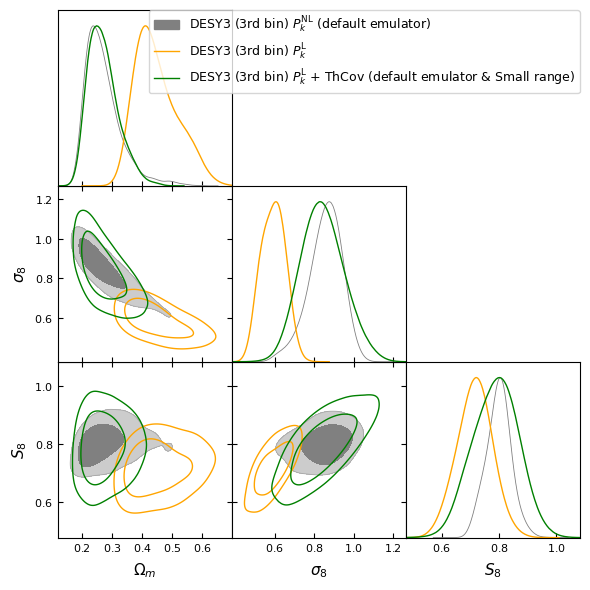

In [56]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange_default_baccoemu',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange_default_baccoemu'
         ]

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])


[root] *WARNING* auto bandwidth for limber_DESY3wl__3_dz very small or failed (h=0.0013607554268213642,N_eff=1822.1337530516716). Using fallback (h=0.01984402564437641)


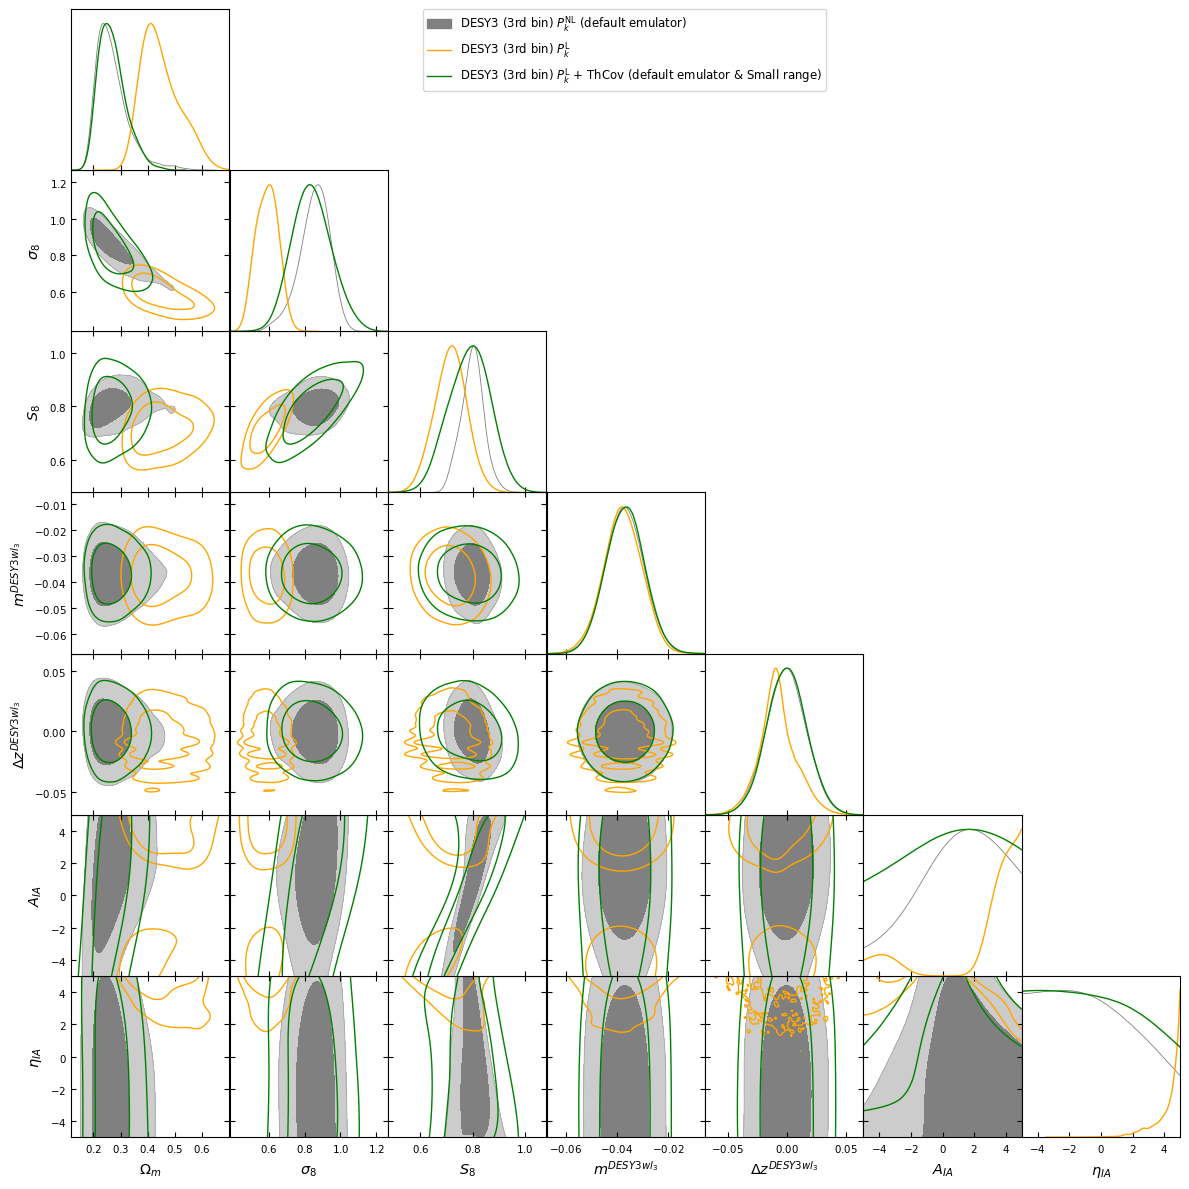

In [57]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange_default_baccoemu',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange_default_baccoemu'
         ]

parameters = ['Omega_m', 'sigma8', 'S8', 'bias_DESY3wl__3_m', 'limber_DESY3wl__3_dz', 'bias_A_IA', 'limber_eta_IA']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=12)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])


### Extended emulator

Chains needed:
 - [x] LinPk
 - [x] LinPk + theory covariance
 - [x] LinPk + scale cuts
 - [x] NonlinPk (BACCOEmu)

In [186]:
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl3_nonlinearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm NL}$ (extended emulator)', 'gray', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$', 'orange', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")


## Case 1 (reality: only within emulator boundaries)
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$ + ThCov (Small range)', 'green', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Case 2 (emulator vs truth)
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$ + ThCov (Priors range)', 'purple', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Scale cuts
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax75_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$ + Linear scale cuts', 'red', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

desy3wl3_nonlinearPk_lmax2048_lmin20 R-1 = 0.015822954988375014
desy3wl3_linearPk_lmax2048_lmin20 R-1 = 0.08783546805239381
desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange R-1 = 0.01151228809878731


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.8661109  0.84618802 0.84494929 ... 0.64182932 0.64182932 0.64182932] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.8661109  0.84618802 0.84494929 ... 0.64182932 0.64182932 0.64182932] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")
/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.8581521  0.89545083 0.83198772 ... 0.62215162 0.64757143 0.67828994] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.8581521  0.89545083 0.83198772 ... 0.62215162 0.64757143 0.67828994] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(

desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange R-1 = 0.024149197623800408
desy3wl3_linearPk_lmax75_lmin20 R-1 = 0.020976036661491844


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.58802006 0.59504181 0.58280102 ... 0.67883119 0.67546866 0.61349409] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.58802006 0.59504181 0.58280102 ... 0.67883119 0.67546866 0.61349409] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


Size of the vector: 24 dchi2 = 241.7
Size of the vector: 23 dchi2 = 225.6
Size of the vector: 22 dchi2 = 209.5
Size of the vector: 21 dchi2 = 193.8
Size of the vector: 20 dchi2 = 178.3
Size of the vector: 19 dchi2 = 162.8
Size of the vector: 18 dchi2 = 147.5
Size of the vector: 17 dchi2 = 132.0
Size of the vector: 16 dchi2 = 117.1
Size of the vector: 15 dchi2 = 102.0
Size of the vector: 14 dchi2 = 87.6
Size of the vector: 13 dchi2 = 74.5
Size of the vector: 12 dchi2 = 61.6
Size of the vector: 11 dchi2 = 49.4
Size of the vector: 10 dchi2 = 38.4
Size of the vector: 9 dchi2 = 29.2
Size of the vector: 8 dchi2 = 22.4
Size of the vector: 7 dchi2 = 16.7
Size of the vector: 6 dchi2 = 11.7
Size of the vector: 5 dchi2 = 7.4
Size of the vector: 4 dchi2 = 3.7
Size of the vector: 3 dchi2 = 1.4


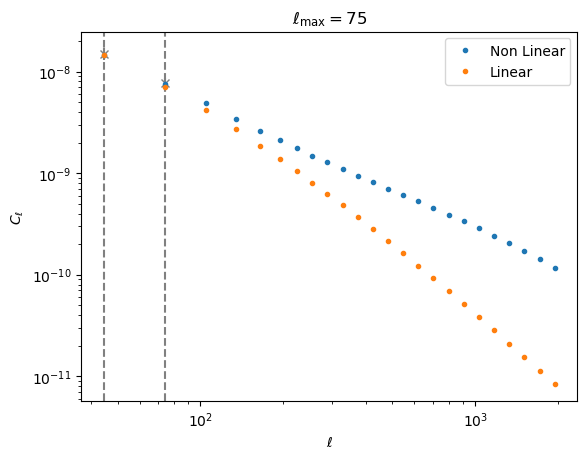

In [125]:
## Find scale cuts

ref_chain = 'desy3wl3_nonlinearPk_lmax2048_lmin20'
bad_chain = 'desy3wl3_linearPk_lmax2048_lmin20'

slinear = find_scale_cuts(ref_chain=ref_chain, bad_chain=bad_chain)

sdata = results[ref_chain].get_cl_data_sacc()
s_th_ref = results[ref_chain].get_cl_theory_sacc_bf()
pars_bf = results[ref_chain]['pars_bf']
s_th_bad = results[bad_chain].get_cl_theory_sacc(pars_bf)

# ell, cl, cov = sdata.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
# err = np.sqrt(np.diag(cov))
# plt.errorbar(ell, cl, yerr=err, fmt='.', color='k')

ell, cl, cov = slinear.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
err = np.sqrt(np.diag(cov))
plt.errorbar(ell, cl, yerr=err, fmt='x', color='gray')
plt.axvline(ell[0], color='gray', ls='--')
plt.axvline(ell[-1], color='gray', ls='--')
lmax = ell[-1]

ell, cl, = s_th_ref.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3')
plt.errorbar(ell, cl, fmt='.', label='Non Linear')

ell, cl = s_th_bad.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3')
plt.errorbar(ell, cl, fmt='.', label='Linear')

plt.legend()
plt.ylabel('$C_\ell$')
plt.xlabel('$\ell$')

plt.title(rf"$\ell_{{\rm max}} = {lmax:.0f}$")

plt.loglog()
plt.show()
plt.close()

In [190]:
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl3_linearPk_lmax75_lmin20'
         ]
for c in chains:
    print(f"chi2({c}) = {results[c]['chi2bf']:.1f} (p = {results[c]['pvalue_bf']:.2f})")

chi2(desy3wl3_nonlinearPk_lmax2048_lmin20) = 23.7 (p = 0.36)
chi2(desy3wl3_linearPk_lmax2048_lmin20) = 67.8 (p = 0.00)
chi2(desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange) = 24.4 (p = 0.33)
chi2(desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange) = 24.9 (p = 0.30)
chi2(desy3wl3_linearPk_lmax75_lmin20) = 0.0 (p = nan)


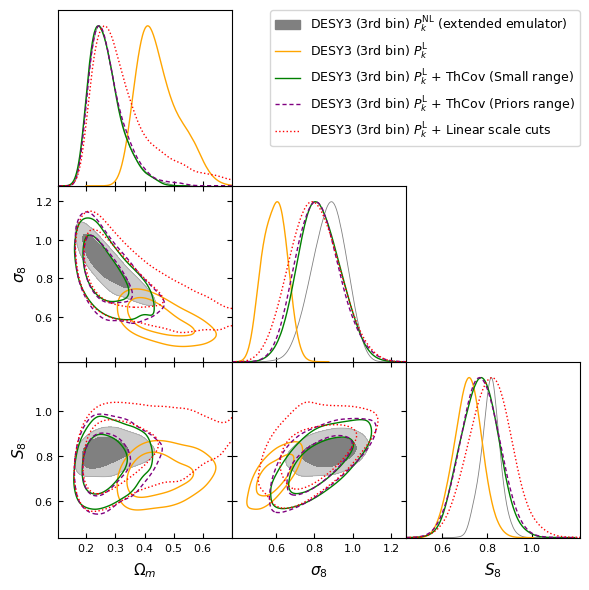

In [188]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl3_linearPk_lmax75_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


[root] *WARNING* auto bandwidth for limber_DESY3wl__3_dz very small or failed (h=0.0013607554268213642,N_eff=1822.1337530516716). Using fallback (h=0.01984402564437641)


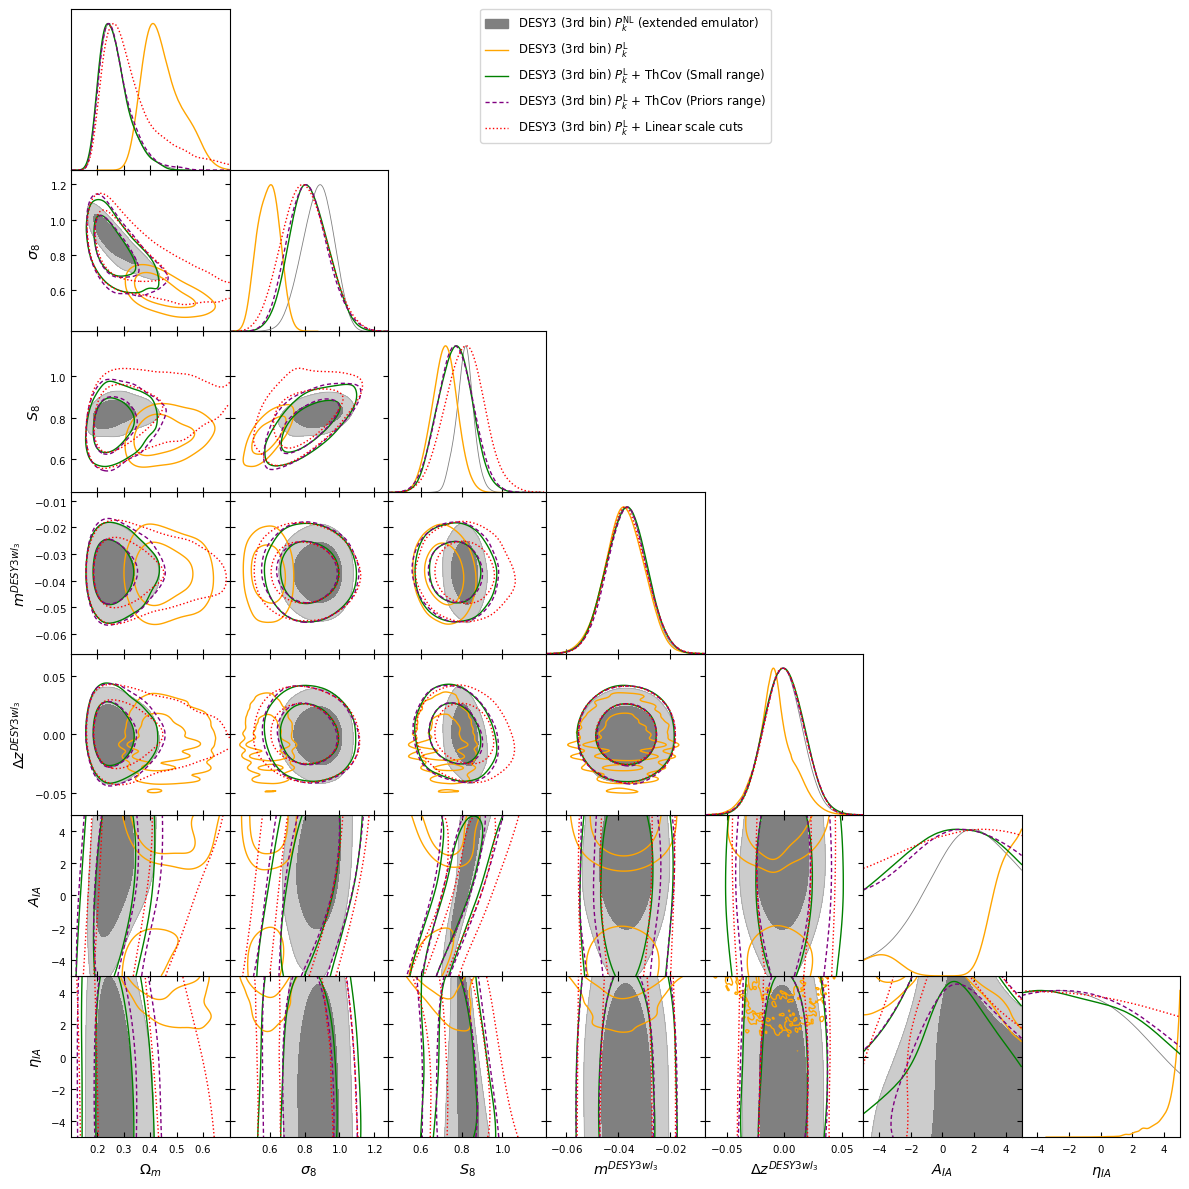

In [189]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl3_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl3_linearPk_lmax75_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8', 'bias_DESY3wl__3_m', 'limber_DESY3wl__3_dz', 'bias_A_IA', 'limber_eta_IA']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=12)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


## All bins

Chains needed:
 - [x] LinPk
 - [x] LinPk + theory covariance (Small range)
 - [x] LinPk + theory covariance (Priors range)
 - [x] LinPk + scale cuts
 - [x] NonlinPk (BACCOEmu)

In [200]:
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl_nonlinearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_GNG',
                           r'DESY3 $P_k^{\rm NL}$ (extended emulator)', 'gray', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl_linearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 $P_k^{\rm L}$', 'orange', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")


## Case 1 (reality: only within emulator boundaries)
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
# key = 'desy3wl_linearPk_lmax2048_lmin20_ThCovSmallRange'
# results[key] = load_chain(f'./chains/{key}/{key}',
#                            r'DESY3 $P_k^{\rm L}$ + ThCov (Small range)', 'green', 0.15, baccoemu=False)
# print(key, f"R-1 = {results[key]['R-1']}")

## Case 2 (emulator vs truth)
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 $P_k^{\rm L}$ + ThCov (Priors range)', 'purple', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Scale cuts
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
# key = 'desy3wl_linearPk_lmaxScaleCuts_lmin20'
# results[key] = load_chain(f'./chains/{key}/{key}',
#                            r'DESY3 $P_k^{\rm L}$ + Linear scale cuts', 'red', 0.15, baccoemu=False)
# print(key, f"R-1 = {results[key]['R-1']}")

desy3wl_nonlinearPk_lmax2048_lmin20 R-1 = 0.029718756722654588


[root] *WARNING* outlier fraction 0.10357958872810358 


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.72330697 0.72330697 0.72330697 ... 0.89470543 0.89470543 0.89470543] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.72330697 0.72330697 0.72330697 ... 0.89470543 0.89470543 0.89470543] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


desy3wl_linearPk_lmax2048_lmin20 R-1 = 58.09650169339491
desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange R-1 = 0.016637957880928318


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.77834876 0.77834876 0.77834876 ... 0.58991554 0.58991554 0.58991554] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.77834876 0.77834876 0.77834876 ... 0.58991554 0.58991554 0.58991554] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


lmax(('DESY3wl__0', 'DESY3wl__0')) = 45
lmax(('DESY3wl__0', 'DESY3wl__1')) = 45
lmax(('DESY3wl__0', 'DESY3wl__2')) = 45
lmax(('DESY3wl__0', 'DESY3wl__3')) = 45
lmax(('DESY3wl__1', 'DESY3wl__1')) = 45
lmax(('DESY3wl__1', 'DESY3wl__2')) = 45
lmax(('DESY3wl__1', 'DESY3wl__3')) = 75
lmax(('DESY3wl__2', 'DESY3wl__2')) = 75
lmax(('DESY3wl__2', 'DESY3wl__3')) = 75
lmax(('DESY3wl__3', 'DESY3wl__3')) = 75


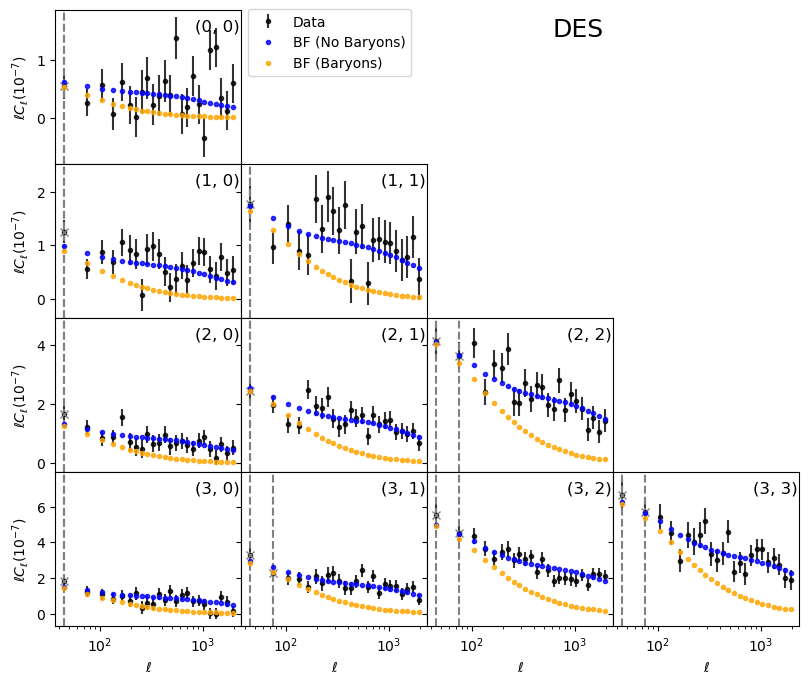

In [204]:
## Find scale cuts

ref_chain = 'desy3wl_nonlinearPk_lmax2048_lmin20'
bad_chain = 'desy3wl_linearPk_lmax2048_lmin20'

# slinear = find_scale_cuts(ref_chain=ref_chain, bad_chain=bad_chain)
# slinear.save_fits('../data/cls_cov_GNG_LinNonlin_ScaleCuts.fits')
sdata = results[ref_chain].get_cl_data_sacc()
s_th_ref = results[ref_chain].get_cl_theory_sacc_bf()
pars_bf = results[ref_chain]['pars_bf']
s_th_bad = results[bad_chain].get_cl_theory_sacc(pars_bf)

survey = 'DES'
nbin = 4
f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in sdata.get_tracer_combinations():
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = sdata.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='Data', alpha=0.8)    

    # Linear scales
    ell, cl = slinear.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='x', color='gray')
    ax[i, j].axvline(ell[0], color='gray', ls='--')
    ax[i, j].axvline(ell[-1], color='gray', ls='--')

    print(f"lmax({trs[0], trs[1]}) = {ell[-1]:.0f}")
    
    # BACCOEMU
    ell, cl = s_th_ref.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='.', color='blue', label='BF (No Baryons)', alpha=0.8)

    # HALOFIT
    ell, cl = s_th_bad.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='.', color='orange', label='BF (Baryons)', alpha=0.8)

    
    t = ax[i, j].text(0.99, 0.94, f'({i}, {j})', horizontalalignment='right',
                      verticalalignment='top', transform=ax[i, j].transAxes, fontsize=12) 
    
    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))

plt.show()
plt.close()

In [207]:
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_linearPk_lmax2048_lmin20',
          # 'desy3wl_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl_linearPk_lmaxScaleCuts_lmin20'
         ]
for c in chains:
    print(f"chi2({c}) = {results[c]['chi2bf']:.1f} (p = {results[c]['pvalue_bf']:.2f})")

chi2(desy3wl_nonlinearPk_lmax2048_lmin20) = 264.8 (p = 0.11)
chi2(desy3wl_linearPk_lmax2048_lmin20) = 730.5 (p = 0.00)
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']


[prior] *WARNING* External prior 'omegab' loaded. Mind that it might not be normalized!
chi2(desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange) = 281.4 (p = 0.03)


[root] *WARNING* outlier fraction 0.10357958872810358 


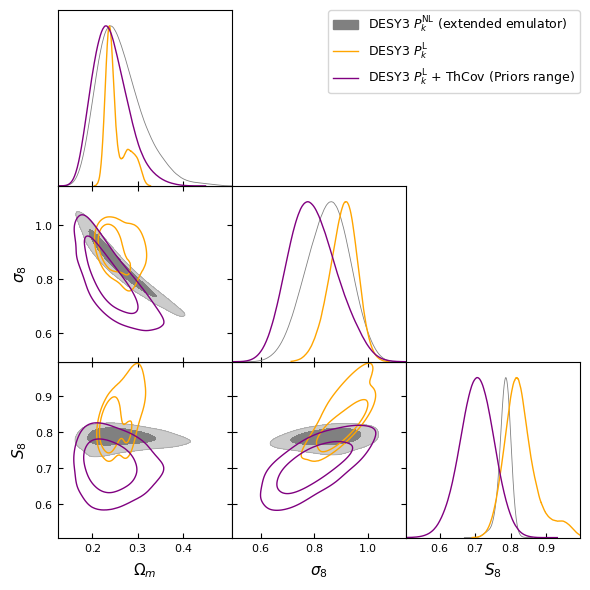

In [208]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_linearPk_lmax2048_lmin20',
          # 'desy3wl_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl_linearPk_lmaxScaleCuts_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


[root] *WARNING* 2D kernel density bandwidth optimizer failed for Omega_m, limber_DESY3wl__3_dz. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for S8, limber_DESY3wl__3_dz. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for limber_DESY3wl__3_dz, bias_A_IA. Using fallback width: f(a) and f(b) must have different signs


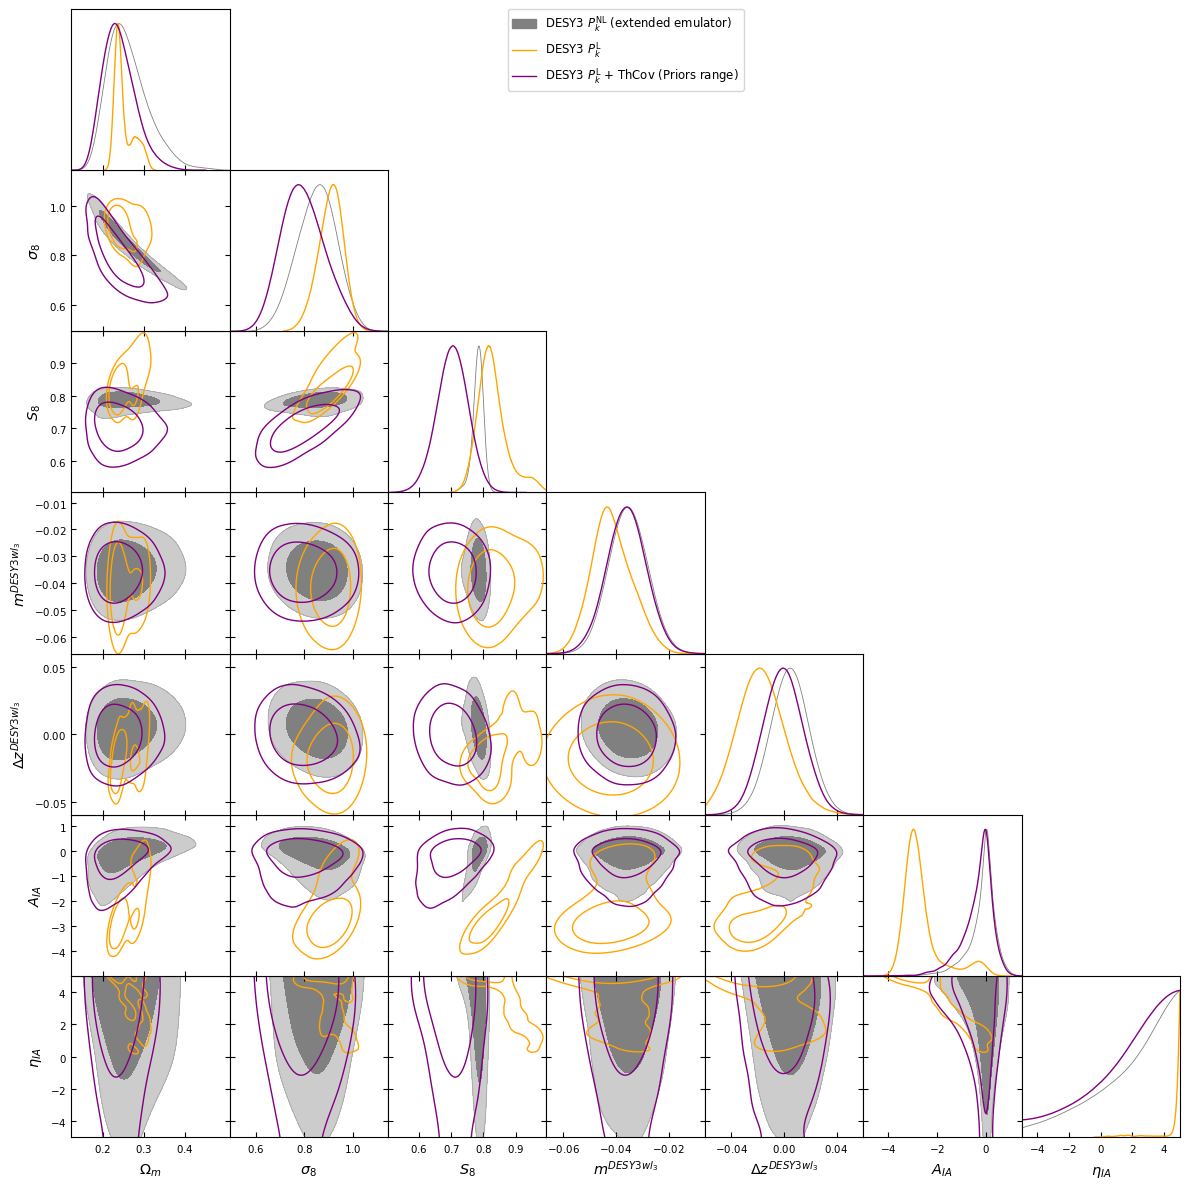

In [209]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_linearPk_lmax2048_lmin20',
          # 'desy3wl_linearPk_lmax2048_lmin20_ThCovSmallRange',
          'desy3wl_linearPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl_linearPk_lmaxScaleCuts_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8', 'bias_DESY3wl__3_m', 'limber_DESY3wl__3_dz', 'bias_A_IA', 'limber_eta_IA']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=12)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


# HALOFIT vs BACCOEmu

In this case we aim to recover unbiased results when we use HALOFIT instead of BACCOEmu in the analysis. We compare 3 runs:
 - HALOFIT
 - HALOFIT + theory covariance
 - HALOFIT + scale cuts
 - BACCOEmu

There might be two different Non Linear Pk's. We can use
 - The default baccoemu emulator. More precise but smaller range of parater space.
 - The enlarged baccoemu emulator that we used to analyse weak lensing data sets.

In both cases, we default to HALOFIT beyond the emulator ranges. The extrapolation in k is done as in CCL with a quadratic spline.

How do we compute the theory covariance.
 - Case 1) ~~Using a Delta Pk measured within the boundaries of the default emulator (small range). This would be the equivalent to the case we produce a theoretical covariance for baccoemu (emulator vs truth).~~ **In this case it doesn't make sense because we know how we are extrapolating**
 - Case 2) Using a Delta Pk measured within the whole parameter space (respect to the emulator within its boundaries and HALOFIT beyond them). This would be case where we completely know the ground truth.

The fiducial case would be the enlarged emulator for coherence with the other parts of the analysis. I have only run with the enlarged emulator this time

## Only DESY3__3 [These don't have omega_b prior]

Chains needed:
 - [x] HALOFIT
 - [x] HALOFIT + theory covariance
 - [x] HALOFIT + scale cuts
 - [x] BACCOEmu

In [215]:
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl3_nonlinearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) BaccoEmu (extended emulator)', 'gray', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_HFITPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) HALOFIT', 'orange', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Case 1 (reality: only within emulator boundaries) --> Doesn't make sense this time because we know how we extrapolate

## Case 2 (emulator vs truth)
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) HALOFIT + ThCov (Priors range)', 'purple', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Scale cuts
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl3_linearPk_lmax75_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 (3rd bin) $P_k^{\rm L}$ + Linear scale cuts', 'red', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

desy3wl3_nonlinearPk_lmax2048_lmin20 R-1 = 0.015822954988375014
desy3wl3_HFITPk_lmax2048_lmin20 R-1 = 0.04956146938892189


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.58433804 0.58433804 0.60088494 ... 0.59605511 0.59808365 0.59984029] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.58433804 0.58433804 0.60088494 ... 0.59605511 0.59808365 0.59984029] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange R-1 = 0.021160151984302922
desy3wl3_linearPk_lmax75_lmin20 R-1 = 0.020976036661491844


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.60959304 0.60175019 0.60175019 ... 0.67972967 0.67972967 0.60911486] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.60959304 0.60175019 0.60175019 ... 0.67972967 0.67972967 0.60911486] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")
/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.58802006 0.59504181 0.58280102 ... 0.67883119 0.67546866 0.61349409] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.58802006 0.59504181 0.58280102 ... 0.67883119 0.67546866 0.61349409] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(

Size of the vector: 24 dchi2 = 2.1
Size of the vector: 13 dchi2 = 0.9


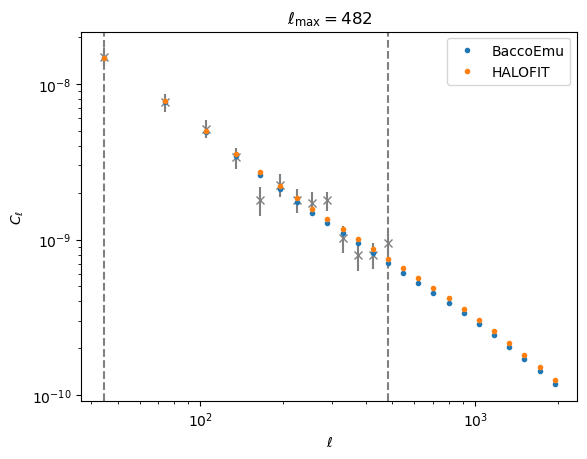

In [170]:
## Find scale cuts
ref_chain = 'desy3wl3_nonlinearPk_lmax2048_lmin20'
bad_chain = 'desy3wl3_HFITPk_lmax2048_lmin20'

slinear = find_scale_cuts(ref_chain=ref_chain, bad_chain=bad_chain)

sdata = results[ref_chain].get_cl_data_sacc()
s_th_ref = results[ref_chain].get_cl_theory_sacc_bf()
pars_bf = results[ref_chain]['pars_bf']
s_th_bad = results[bad_chain].get_cl_theory_sacc(pars_bf)

# ell, cl, cov = sdata.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
# err = np.sqrt(np.diag(cov))
# plt.errorbar(ell, cl, yerr=err, fmt='.', color='k')

ell, cl, cov = slinear.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
err = np.sqrt(np.diag(cov))
plt.errorbar(ell, cl, yerr=err, fmt='x', color='gray')
plt.axvline(ell[0], color='gray', ls='--')
plt.axvline(ell[-1], color='gray', ls='--')
lmax = ell[-1]

ell, cl, = s_th_ref.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3')
plt.errorbar(ell, cl, fmt='.', label='BaccoEmu')

ell, cl = s_th_bad.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3')
plt.errorbar(ell, cl, fmt='.', label='HALOFIT')

plt.legend()
plt.ylabel('$C_\ell$')
plt.xlabel('$\ell$')

plt.title(rf"$\ell_{{\rm max}} = {lmax:.0f}$")

plt.loglog()
plt.show()
plt.close()

In [217]:
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl3_linearPk_lmax75_lmin20'
         ]
for c in chains:
    print(f"chi2({c}) = {results[c]['chi2bf']:.1f} (p = {results[c]['pvalue_bf']:.2f})")

chi2(desy3wl3_nonlinearPk_lmax2048_lmin20) = 23.7 (p = 0.36)
chi2(desy3wl3_HFITPk_lmax2048_lmin20) = 23.7 (p = 0.36)
chi2(desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange) = 23.6 (p = 0.37)


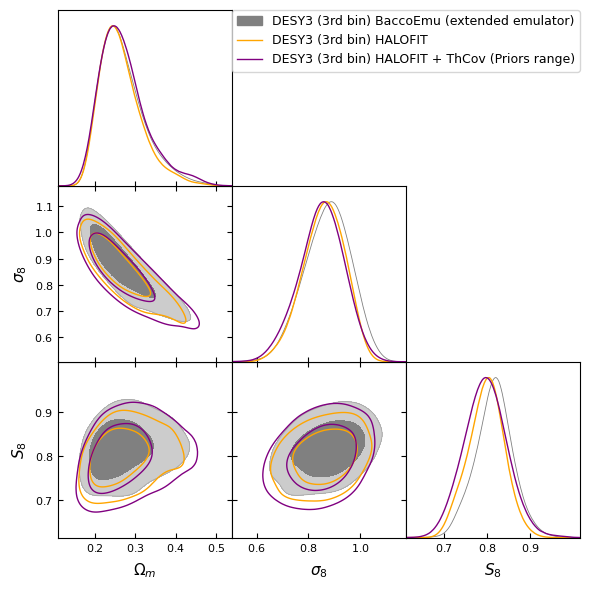

In [218]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl3_linearPk_lmax75_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


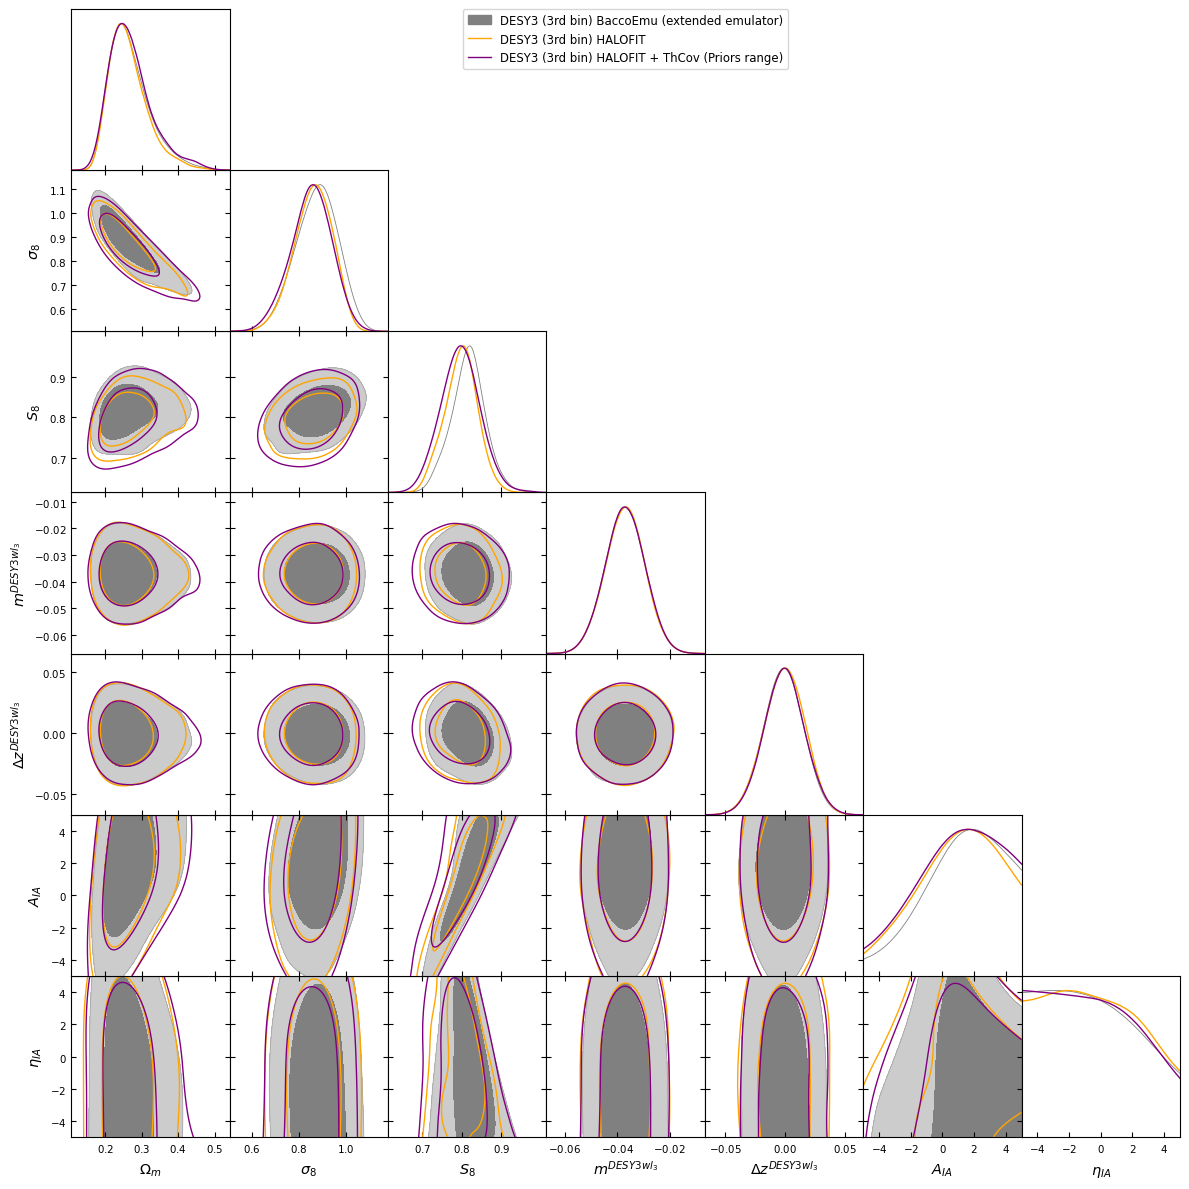

In [219]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20',
          'desy3wl3_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          # 'desy3wl3_linearPk_lmax75_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8', 'bias_DESY3wl__3_m', 'limber_DESY3wl__3_dz', 'bias_A_IA', 'limber_eta_IA']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=12)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


## All bins

Chains needed:
 - [x] HALOFIT
 - [x] HALOFIT + theory covariance
 - [x] HALOFIT + scale cuts
 - [x] BACCOEmu

In [210]:
# DESY3 with non-linear Pk from (extended) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl_nonlinearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_GNG',
                           r'DESY3 BaccoEmu (extended emulator)', 'gray', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu
key = 'desy3wl_HFITPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_halofit_GNG',
                           r'DESY3 HALOFIT', 'orange', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")


## Case 1 (reality: only within emulator boundaries) --> Doesn't make sense this time because we know how we extrapolate

## Case 2 (emulator vs truth)
# DESY3 with non-linear Pk from (default) baccoemu
key = 'desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 HALOFIT + ThCov (Priors range)', 'purple', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

## Scale cuts
# DESY3 with non-linear Pk from (default) baccoemu
key = 'desy3wl_HFITPk_lmaxScaleCuts_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 $P_k^{\rm L}$ + Linear scale cuts', 'red', 0.15, baccoemu=False)
print(key, f"R-1 = {results[key]['R-1']}")

desy3wl_nonlinearPk_lmax2048_lmin20 R-1 = 0.029718756722654588


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.73053731 0.72926546 0.75944257 ... 0.7785936  0.78315535 0.78315535] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.73053731 0.72926546 0.75944257 ... 0.7785936  0.78315535 0.78315535] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


desy3wl_HFITPk_lmax2048_lmin20 R-1 = 0.061083615242992065


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.61425387 0.72388898 0.72388898 ... 0.87509451 0.90255115 0.90255115] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.61425387 0.72388898 0.72388898 ... 0.87509451 0.90255115 0.90255115] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange R-1 = 0.055189494330467936
desy3wl_HFITPk_lmaxScaleCuts_lmin20 R-1 = 0.05105236913707422


/tmp/ipykernel_31858/3574808074.py:187: UserWarning: Param hubble=[0.85457605 0.85457605 0.85457605 ... 0.55977795 0.55977795 0.55977795] out of bounds [0.5, 0.9] Not adding S12 for this chain.
  warnings.warn(str(e) + " Not adding S12 for this chain.")
/tmp/ipykernel_31858/3574808074.py:206: UserWarning: Param hubble=[0.85457605 0.85457605 0.85457605 ... 0.55977795 0.55977795 0.55977795] out of bounds [0.5, 0.9] Not adding sigma8_cold for this chain.
  warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")


lmax(('DESY3wl__0', 'DESY3wl__0')) = 1949
lmax(('DESY3wl__0', 'DESY3wl__1')) = 425
lmax(('DESY3wl__0', 'DESY3wl__2')) = 374
lmax(('DESY3wl__0', 'DESY3wl__3')) = 425
lmax(('DESY3wl__1', 'DESY3wl__1')) = 425
lmax(('DESY3wl__1', 'DESY3wl__2')) = 374
lmax(('DESY3wl__1', 'DESY3wl__3')) = 374
lmax(('DESY3wl__2', 'DESY3wl__2')) = 374
lmax(('DESY3wl__2', 'DESY3wl__3')) = 374
lmax(('DESY3wl__3', 'DESY3wl__3')) = 425


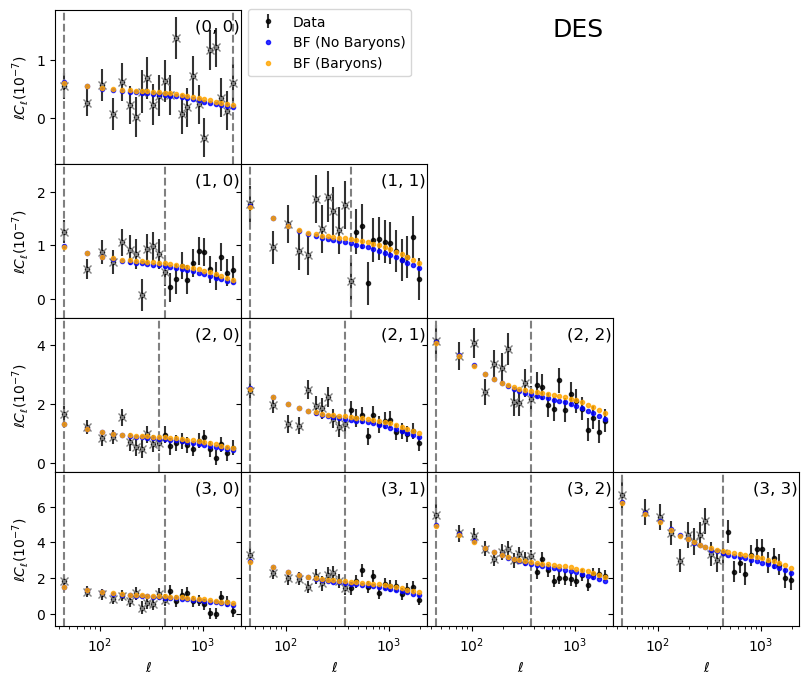

In [185]:
## Find scale cuts
ref_chain = 'desy3wl_nonlinearPk_lmax2048_lmin20'
bad_chain = 'desy3wl_HFITPk_lmax2048_lmin20'

# slinear = find_scale_cuts(ref_chain=ref_chain, bad_chain=bad_chain)
# slinear.save_fits('../data/cls_cov_GNG_HFITvsBaccoEmu_ScaleCuts.fits')
# sdata = results[ref_chain].get_cl_data_sacc()
# s_th_ref = results[ref_chain].get_cl_theory_sacc_bf()
# pars_bf = results[ref_chain]['pars_bf']
# s_th_bad = results[bad_chain].get_cl_theory_sacc(pars_bf)

survey = 'DES'
nbin = 4
f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in sdata.get_tracer_combinations():
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = sdata.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='Data', alpha=0.8)    

    # Linear scales
    ell, cl = slinear.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='x', color='gray')
    ax[i, j].axvline(ell[0], color='gray', ls='--')
    ax[i, j].axvline(ell[-1], color='gray', ls='--')

    print(f"lmax({trs[0], trs[1]}) = {ell[-1]:.0f}")
    
    # BACCOEMU
    ell, cl = s_th_ref.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='.', color='blue', label='BF (No Baryons)', alpha=0.8)

    # HALOFIT
    ell, cl = s_th_bad.get_ell_cl('cl_ee', trs[0], trs[1])
    ax[i, j].errorbar(ell, ell * cl * 1e7, fmt='.', color='orange', label='BF (Baryons)', alpha=0.8)

    
    t = ax[i, j].text(0.99, 0.94, f'({i}, {j})', horizontalalignment='right',
                      verticalalignment='top', transform=ax[i, j].transAxes, fontsize=12) 
    
    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))

plt.show()
plt.close()

In [212]:
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl_HFITPk_lmaxScaleCuts_lmin20'
         ]
for c in chains:
    print(f"chi2({c}) = {results[c]['chi2bf']:.1f} (p = {results[c]['pvalue_bf']:.2f})")

chi2(desy3wl_nonlinearPk_lmax2048_lmin20) = 264.8 (p = 0.11)
chi2(desy3wl_HFITPk_lmax2048_lmin20) = 264.4 (p = 0.12)
chi2(desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange) = 264.3 (p = 0.12)
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']


[prior] *WARNING* External prior 'omegab' loaded. Mind that it might not be normalized!
chi2(desy3wl_HFITPk_lmaxScaleCuts_lmin20) = 154.2 (p = 0.04)


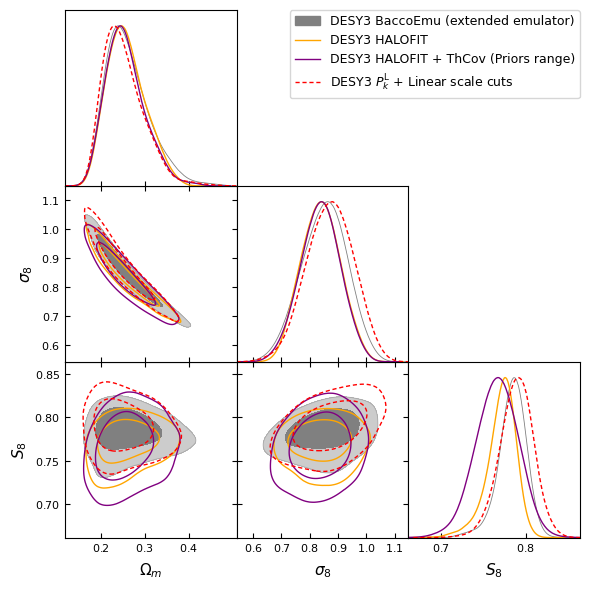

In [213]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl_HFITPk_lmaxScaleCuts_lmin20'
         ]

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


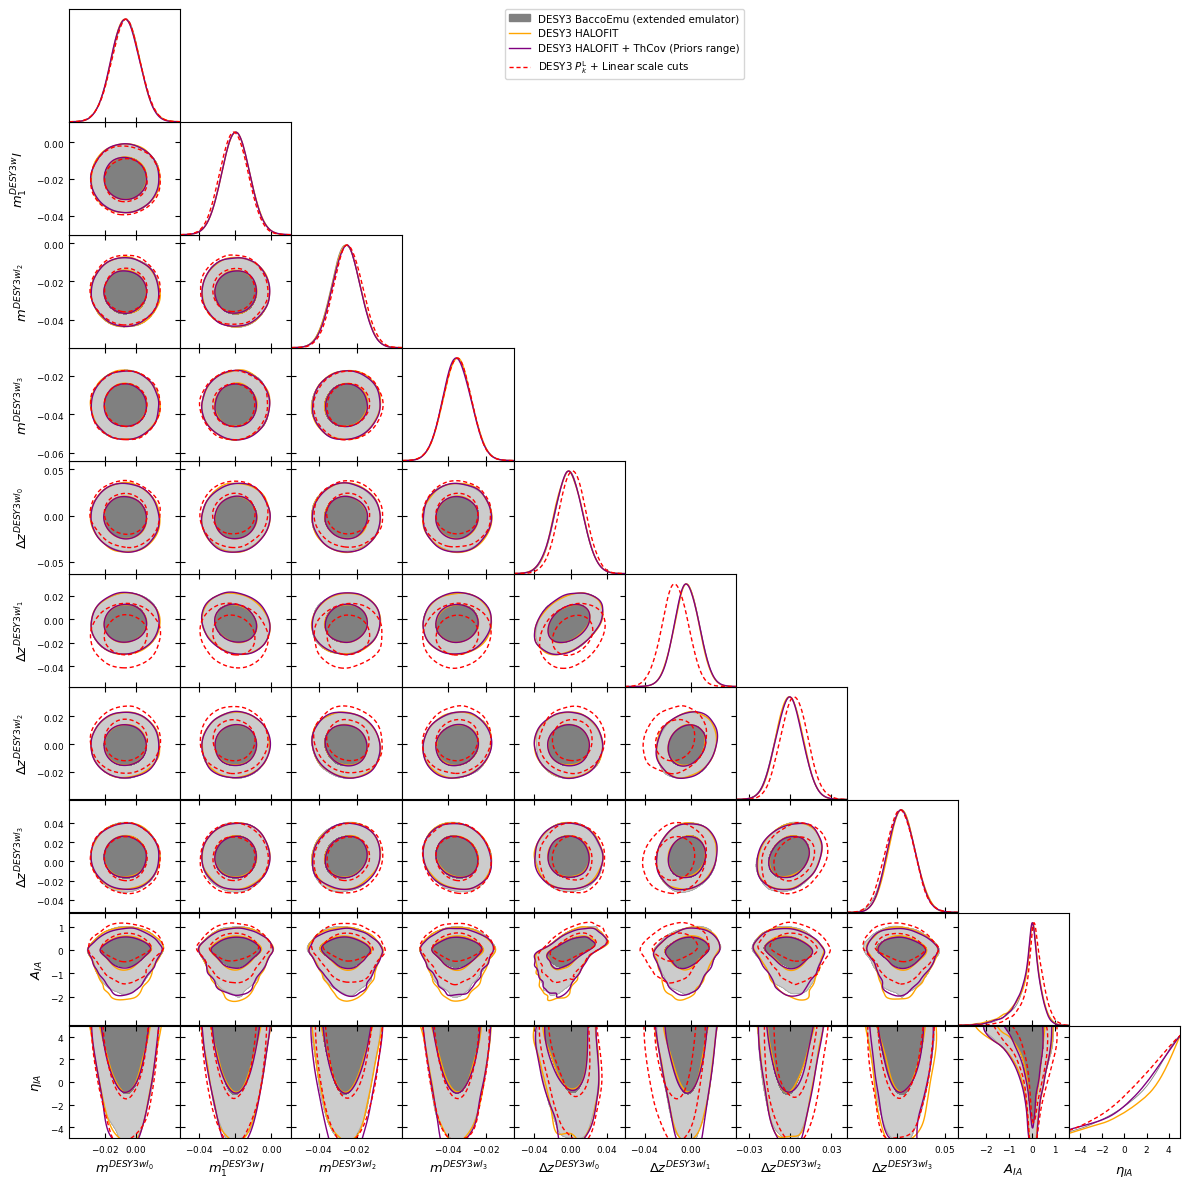

In [214]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20',
          'desy3wl_HFITPk_lmax2048_lmin20_ThCovPriorsRange',
          'desy3wl_HFITPk_lmaxScaleCuts_lmin20'
         ]

parameters = [f'bias_DESY3wl__{i}_m' for i in range(4)]
parameters += [f'limber_DESY3wl__{i}_dz' for i in range(4)]
parameters += ['bias_A_IA', 'limber_eta_IA']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=12)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1, 1], contour_ls=['-', '-', '-', '--', ':'])


# Test

In [29]:
# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl_nonlinearPk_lmax2048_lmin20'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 $P_k^{\rm NL}$ (extended emulator)', 'orange', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

# DESY3 (3rd bin) with non-linear Pk from (default) baccoemu + halofit extrapolation beyond the boundaries of the emulator space.
key = 'desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_GNG'
results[key] = load_chain(f'../../shear-baryons/mcmc/chains/{key}/{key}',
                           r'DESY3 $P_k^{\rm NL}$ (extended emulator) Run from baryons paper', 'red', 0.15)
print(key, f"R-1 = {results[key]['R-1']}")

desy3wl_nonlinearPk_lmax2048_lmin20 R-1 = 0.05498388687188738
desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_GNG R-1 = 0.029718756722654477


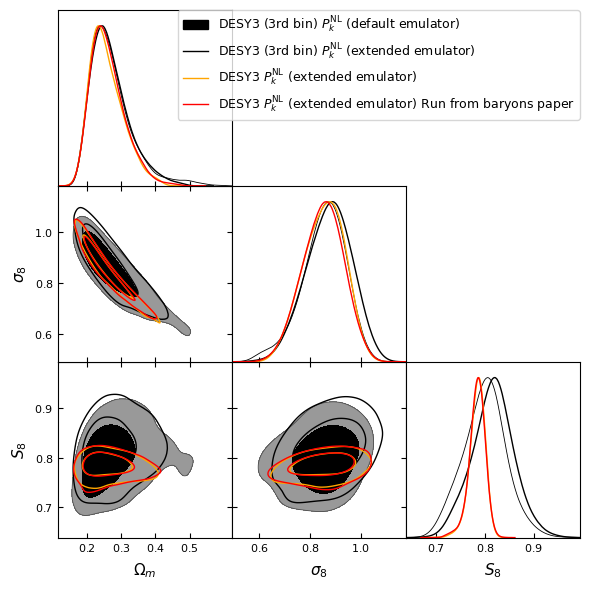

In [30]:
# Baryons vs no Baryons with ell_max=2048
chains = ['desy3wl3_nonlinearPk_lmax2048_lmin20_SmallRange',
          'desy3wl3_nonlinearPk_lmax2048_lmin20',
          'desy3wl_nonlinearPk_lmax2048_lmin20',
          'desy3wl_nobaryons_nocuts_nla_nside4096_lmax2048_lmin20_GNG']

parameters = ['Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]


g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])
